In [1]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Loading the Dataset

In [2]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')

# Keep lon/lat for visualization only
lon_lat = dataset[['lon', 'lat']].copy()

# Remove lon/lat and fire from clustering
dataset.drop(columns=['lon', 'lat', 'fire'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X = dataset.copy()
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])

print("=== X shape:", X.shape)
print("=== X columns:", X.columns)

X_array = X.to_numpy()

=== Dataset Types :
 log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  float64
CEC_SOIL                  f

# Scratch Model Implementation

In [3]:
import numpy as np

class CLARANS:
    """
    CLARANS: Clustering Large Applications based upon RANdomized Search
    
    Parameters:
    -----------
    n_clusters : int
        Number of clusters (medoids) to find
    numlocal : int
        Number of local minima to find
    maxneighbor : int
        Maximum number of neighbors to examine in each search
    random_state : int
        Random seed for reproducibility
    """
    
    def __init__(self, n_clusters=3, numlocal=2, maxneighbor=10, random_state=42):
        self.n_clusters = n_clusters
        self.numlocal = numlocal
        self.maxneighbor = maxneighbor
        self.random_state = random_state
        self.medoid_indices_ = None
        self.labels_ = None
        self.inertia_ = None
        
    def _compute_distance_matrix(self, X):
        """Compute pairwise Euclidean distances"""
        n = X.shape[0]
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            dist_matrix[i] = np.linalg.norm(X - X[i], axis=1)
        
        return dist_matrix
    
    def _assign_clusters(self, dist_matrix, medoid_indices):
        """Assign each point to nearest medoid"""
        distances_to_medoids = dist_matrix[:, medoid_indices]
        labels = np.argmin(distances_to_medoids, axis=1)
        return labels
    
    def _compute_cost(self, dist_matrix, medoid_indices):
        """Compute total cost (sum of distances to nearest medoid)"""
        distances_to_medoids = dist_matrix[:, medoid_indices]
        min_distances = np.min(distances_to_medoids, axis=1)
        return np.sum(min_distances)
    
    def _get_random_neighbor(self, current_medoids, n_points):
        """Generate a random neighbor by swapping one medoid"""
        neighbor = current_medoids.copy()
        
        # Randomly select a medoid to replace
        medoid_to_replace = np.random.randint(0, self.n_clusters)
        
        # Randomly select a non-medoid point
        non_medoid_points = np.setdiff1d(np.arange(n_points), current_medoids)
        new_medoid = np.random.choice(non_medoid_points)
        
        neighbor[medoid_to_replace] = new_medoid
        return neighbor
    
    def fit(self, X):
        """Fit CLARANS clustering"""
        np.random.seed(self.random_state)
        n_points = X.shape[0]
        
        # Compute distance matrix once
        print("Computing distance matrix...")
        dist_matrix = self._compute_distance_matrix(X)
        
        best_medoids = None
        best_cost = np.inf
        
        print(f"Starting {self.numlocal} local searches...")
        
        for local_search in range(self.numlocal):
            # Initialize with random medoids
            current_medoids = np.random.choice(n_points, self.n_clusters, replace=False)
            current_cost = self._compute_cost(dist_matrix, current_medoids)
            
            neighbors_checked = 0
            
            while neighbors_checked < self.maxneighbor:
                # Get a random neighbor
                neighbor_medoids = self._get_random_neighbor(current_medoids, n_points)
                neighbor_cost = self._compute_cost(dist_matrix, neighbor_medoids)
                
                # If neighbor is better, move to it and reset counter
                if neighbor_cost < current_cost:
                    current_medoids = neighbor_medoids
                    current_cost = neighbor_cost
                    neighbors_checked = 0
                else:
                    neighbors_checked += 1
            
            # Update global best
            if current_cost < best_cost:
                best_cost = current_cost
                best_medoids = current_medoids
            
            print(f"Local search {local_search + 1}/{self.numlocal} completed. Cost: {current_cost:.2f}")
        
        # Store results
        self.medoid_indices_ = best_medoids
        self.labels_ = self._assign_clusters(dist_matrix, best_medoids)
        self.inertia_ = best_cost
        
        print(f"\nBest cost found: {best_cost:.2f}")
        print(f"Medoid indices: {best_medoids}")
        
        return self
    
    def predict(self, X_train, X_new):
        """Predict cluster labels for new data"""
        medoid_points = X_train[self.medoid_indices_]
        labels = []
        
        for point in X_new:
            distances = np.linalg.norm(medoid_points - point, axis=1)
            labels.append(np.argmin(distances))
        
        return np.array(labels)

# Scratch Model Training

**Note**: En raison de la complexité computationnelle de CLARANS, nous utilisons un échantillon du dataset pour l'entraînement.

In [4]:
# Use a sample for training due to computational cost
sample_size = min(10000, len(X_array))
np.random.seed(42)
sample_indices = np.random.choice(len(X_array), sample_size, replace=False)
X_sample = X_array[sample_indices]
lon_lat_sample = lon_lat.iloc[sample_indices].reset_index(drop=True)

print(f"Training CLARANS on sample of {sample_size} points...\n")

# Train CLARANS model
clarans = CLARANS(
    n_clusters=5,      # Number of clusters
    numlocal=2,        # Number of local searches
    maxneighbor=10,    # Max neighbors to check
    random_state=42
)

clarans.fit(X_sample)

labels_scratch = clarans.labels_

print(f"\nScratch CLARANS - Number of clusters: {clarans.n_clusters}")
print(f"Scratch CLARANS - Inertia: {clarans.inertia_:.2f}")

Training CLARANS on sample of 10000 points...

Computing distance matrix...
Starting 2 local searches...
Local search 1/2 completed. Cost: 51550.31
Local search 2/2 completed. Cost: 50296.22

Best cost found: 50296.22
Medoid indices: [9401 5389 4013  189 1949]

Scratch CLARANS - Number of clusters: 5
Scratch CLARANS - Inertia: 50296.22


# Scratch Model Evaluation

=== Scratch CLARANS Metrics ===
Silhouette Score: 0.2331
Davies-Bouldin Index: 1.6035
Calinski-Harabasz Index: 1666.6859
Inertia: 50296.22

=== Cluster Distribution ===
Cluster 0: 3737 points (37.37%)
Cluster 1: 554 points (5.54%)
Cluster 2: 2076 points (20.76%)
Cluster 3: 2578 points (25.78%)
Cluster 4: 1055 points (10.55%)


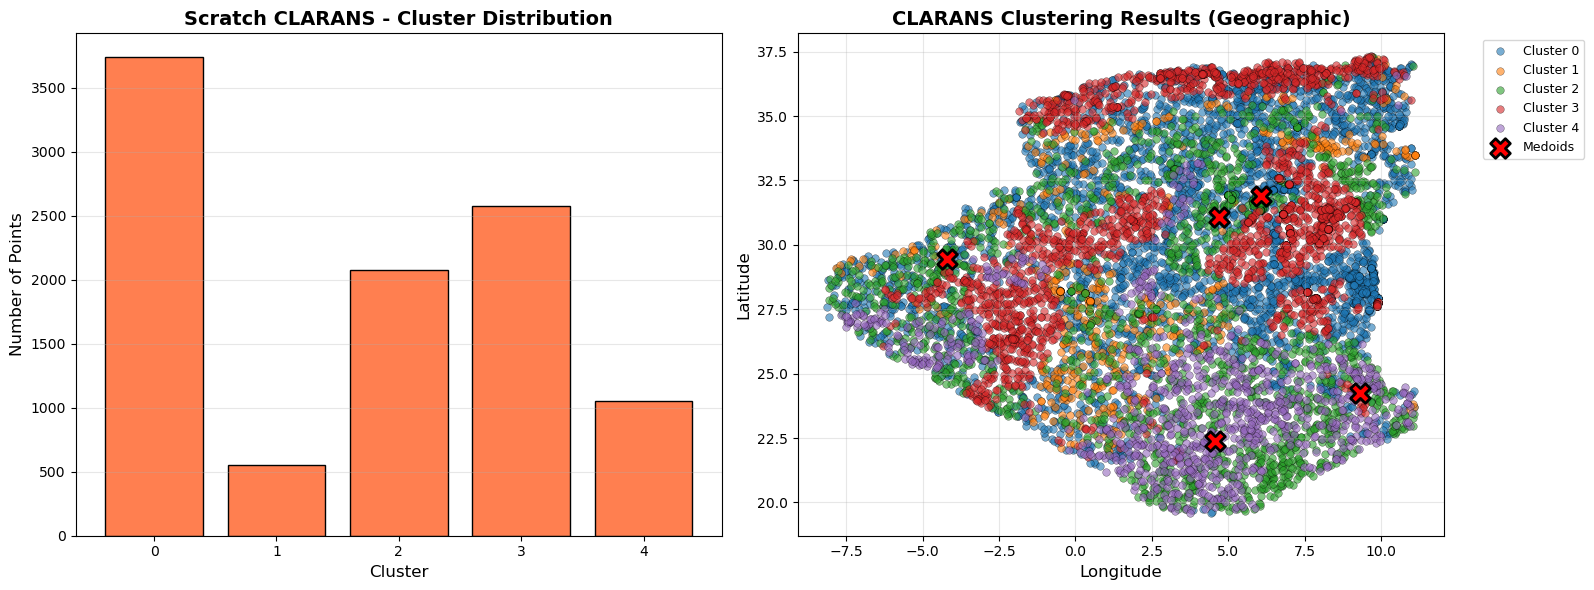

In [5]:
# Calculate clustering metrics
silhouette_scratch = silhouette_score(X_sample, labels_scratch)
davies_bouldin_scratch = davies_bouldin_score(X_sample, labels_scratch)
calinski_harabasz_scratch = calinski_harabasz_score(X_sample, labels_scratch)

print("=== Scratch CLARANS Metrics ===")
print(f"Silhouette Score: {silhouette_scratch:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_scratch:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_scratch:.4f}")
print(f"Inertia: {clarans.inertia_:.2f}")

# Distribution of clusters
unique_scratch, counts_scratch = np.unique(labels_scratch, return_counts=True)
print("\n=== Cluster Distribution ===")
for cluster, count in zip(unique_scratch, counts_scratch):
    print(f"Cluster {cluster}: {count} points ({count/len(labels_scratch)*100:.2f}%)")

# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].bar(unique_scratch, counts_scratch, color='coral', edgecolor='black')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Points', fontsize=12)
axes[0].set_title('Scratch CLARANS - Cluster Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique_scratch)
axes[0].grid(axis='y', alpha=0.3)

# Geographic visualization (lon/lat)
for cluster in unique_scratch:
    mask = labels_scratch == cluster
    axes[1].scatter(lon_lat_sample.loc[mask, 'lon'], lon_lat_sample.loc[mask, 'lat'], 
                   label=f'Cluster {cluster}', 
                   s=30, alpha=0.6, edgecolors='k', linewidth=0.3)

# Mark medoids
medoid_coords = lon_lat_sample.iloc[clarans.medoid_indices_]
axes[1].scatter(medoid_coords['lon'], medoid_coords['lat'], 
               c='red', marker='X', s=200, edgecolors='black', linewidth=2,
               label='Medoids', zorder=5)

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('CLARANS Clustering Results (Geographic)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SKlearn Model Training

Utilisation de la bibliothèque pyclustering pour CLARANS


In [6]:
from pyclustering.cluster.clarans import clarans

# Train CLARANS using pyclustering library
clarans_sklearn = clarans(X_sample.tolist(), 5, 2, 10)
clarans_sklearn.process()

# Get clusters and labels
clusters_sklearn = clarans_sklearn.get_clusters()
medoids_sklearn = clarans_sklearn.get_medoids()

# Convert clusters to labels
labels_sklearn = np.zeros(len(X_sample), dtype=int)
for cluster_id, cluster_points in enumerate(clusters_sklearn):
    for point_idx in cluster_points:
        labels_sklearn[point_idx] = cluster_id

print(f"Sklearn CLARANS - Number of clusters: {len(clusters_sklearn)}")
print(f"Sklearn CLARANS - Medoids: {medoids_sklearn}")


KeyboardInterrupt: 

# SKlearn Model Evaluation
